# 2024-02-11 blog: A Simple, Effective Way to Manage Turnover and Not Get Killed by Costs
https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/#more-89281

In [3]:
install.packages("pacman")

Installing package into ‘/usr/lib64/R/library’
(as ‘lib’ is unspecified)

also installing the dependency ‘remotes’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)  # this will take some time the first time you build the package
library(rsims)
library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

desc      (NA -> 1.4.3) [CRAN]
brio      (NA -> 1.1.4) [CRAN]
diffobj   (NA -> 0.3.5) [CRAN]
rprojroot (NA -> 2.0.4) [CRAN]
pkgbuild  (NA -> 1.4.4) [CRAN]
whisker   (NA -> 0.4.1) [CRAN]
downlit   (NA -> 0.4.3) [CRAN]
waldo     (NA -> 0.5.2) [CRAN]
praise    (NA -> 1.0.0) [CRAN]
pkgload   (NA -> 1.3.4) [CRAN]
pkgdown   (NA -> 2.0.7) [CRAN]
testthat  (NA -> 3.2.1) [CRAN]
here      (NA -> 1.0.1) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp38ckVa/remotes1217a857c3/Robot-Wealth-rsims-5ecb5cb/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.1.0.15.tar.gz’



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter




In [5]:
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
head(perps)

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-09-11,10172.13,10293.11,9884.31,9991.84,85955369,10928,5169.153,52110075,-3e-04
BTCUSDT,2019-09-12,9992.18,10365.15,9934.11,10326.58,157223498,19384,11822.980,119810012,-3e-04
BTCUSDT,2019-09-13,10327.25,10450.13,10239.42,10296.57,189055129,25370,9198.551,94983470,-3e-04
BTCUSDT,2019-09-14,10294.81,10396.40,10153.51,10358.00,206031349,31494,9761.462,100482121,-3e-04
BTCUSDT,2019-09-15,10355.61,10419.97,10024.81,10306.37,211326874,27512,7418.716,76577710,-3e-04
BTCUSDT,2019-09-16,10306.79,10353.81,10115.00,10120.07,208211376,29030,7564.376,77673986,-3e-04


In [6]:
# remove stablecoins
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

perps <- perps %>%
  filter(!ticker %in% glue::glue("{stables}USDT"))

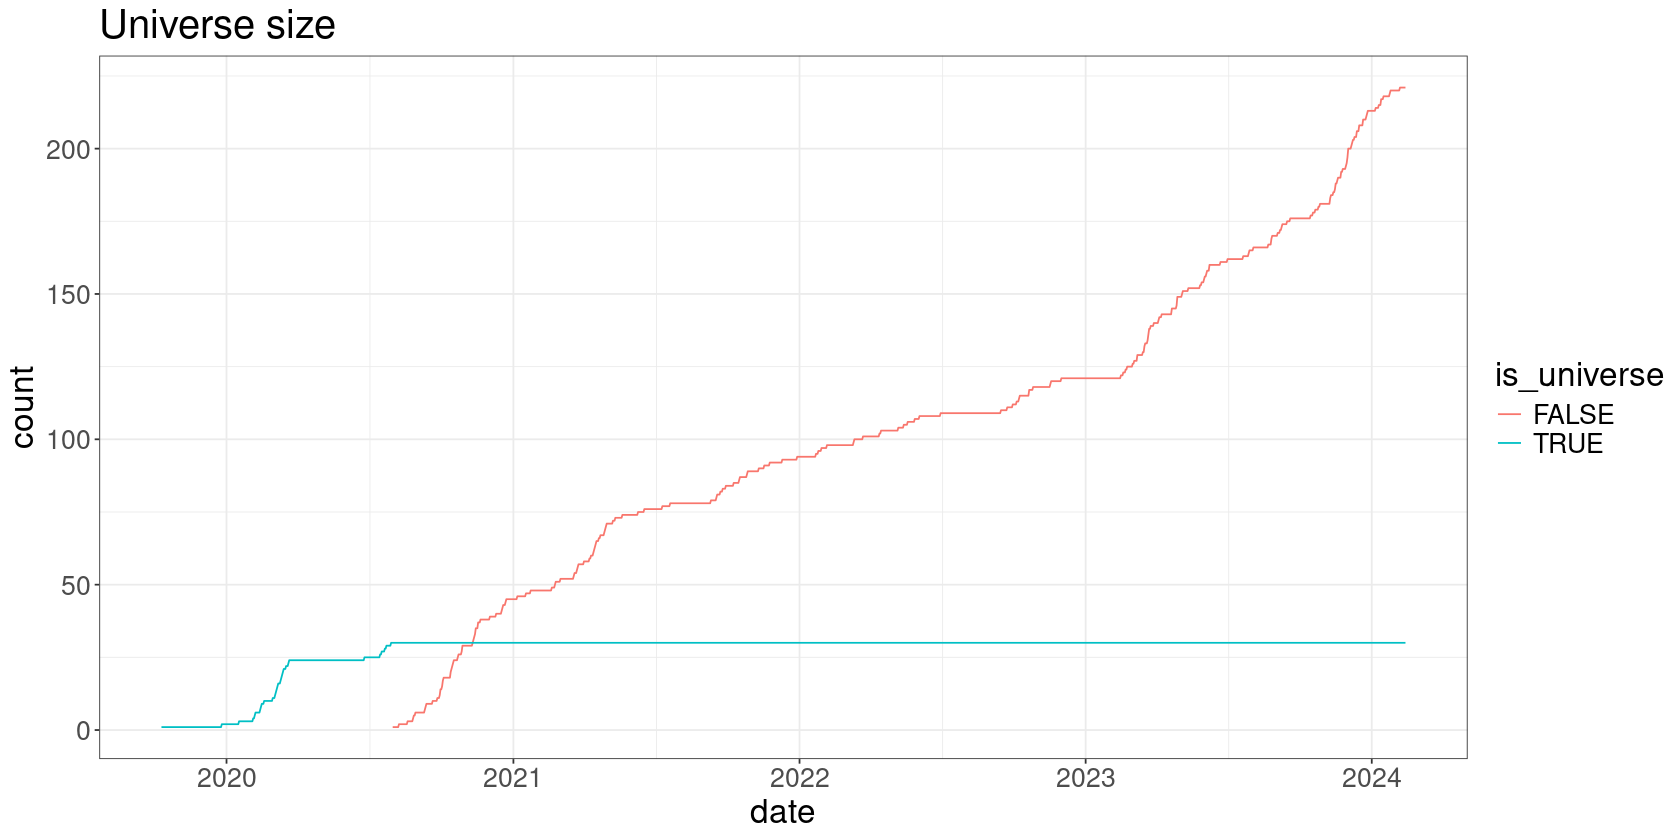

In [7]:
# just get the top 30 by trailing 30-day volume
trading_universe_size <- 30

universe <- perps %>%
  group_by(ticker) %>%
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) +
  geom_line() +
  labs(
    title = 'Universe size'
)

In [8]:
# calculate features
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 20, na_value = NA),
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = lag(9.5 - rolling_days_since_high_20(close)),  # puts this feature on a scale -9.5 to +9.5
    momo = lag(close - lag(close, 10)/close),
    carry = lag(funding_rate)
  ) %>%
  ungroup() %>%
  na.omit()

head(features)

ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate,trail_volume,volume_rank,is_universe,breakout,momo,carry
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-10-30,9352.65,9492.86,8975.72,9102.91,1089606006,267844,58062.12,537610627,-0.00106636,660931006,1,TRUE,7.5,9353.776,-0.00117130
BTCUSDT,2019-10-31,9103.86,9438.64,8933.00,9218.70,851802094,229216,46234.79,423883668,-0.00092829,680429873,1,TRUE,6.5,9102.029,-0.00106636
BTCUSDT,2019-11-01,9218.70,9280.00,9011.00,9084.37,816001159,233091,43506.69,398347973,-0.00074601,698120233,1,TRUE,5.5,9217.811,-0.00092829
BTCUSDT,2019-11-02,9084.37,9375.00,9050.27,9320.00,653539543,204338,35617.67,328788833,-0.00030000,710903610,1,TRUE,4.5,9083.466,-0.00074601
BTCUSDT,2019-11-03,9319.00,9366.69,9105.00,9180.97,609237501,219662,31698.32,292888566,-0.00030000,722483703,1,TRUE,3.5,9319.204,-0.00030000
BTCUSDT,2019-11-04,9180.97,9320.00,9073.00,9292.66,631763431,211571,34375.10,316185069,-0.00030072,735726657,1,TRUE,2.5,9180.160,-0.00030000


In [9]:
# calculate target weights
# filter on is_universe so that we calculate features only for stuff that's in the universe today
# (we'd have to do this differently if any of these calcs depended on past data, eg if we were doing z-score smoothing)
# then, join on original prices for backtesting

# tickers that were ever in the universe
universe_tickers <- features %>%
  filter(is_universe) %>%
  pull(ticker) %>%
  unique()

# print(length(universe_tickers))

# start simulation from date we first have n tickers in the universe
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(date)

# calculate weights
model_df <- features %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    carry_weight = (carry_decile - 5.5),  # will run -4.5 to 4.5
    momo_decile = ntile(momo, 10),
    momo_weight = -(momo_decile - 5.5),  # will run -4.5 to 4.5
    breakout_weight = breakout / 2,
    combined_weight = (0.5*carry_weight + 0.2*momo_weight + 0.3*breakout_weight),
    # scale weights so that abs values sum to 1 - no leverage condition
    scaled_weight = combined_weight/sum(abs(combined_weight))
  )  %>%
  select(date, ticker, scaled_weight) %>%
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    features %>%
      filter(ticker %in% universe_tickers) %>%
      select(date, ticker, close, funding_rate),
    by = c("date", "ticker")
  ) %>%
  # give anything with a NA weight (due to the join) a zero
  replace_na(list(scaled_weight = 0)) %>%
  arrange(date, ticker) %>%
  filter(date >= start_date)

In [10]:
# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_weights <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("scaled_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(date, starts_with("funding_rate_")) %>%
  data.matrix()

head(backtest_funding, c(5, 5))

date,scaled_weight_ADAUSDT,scaled_weight_ALGOUSDT,scaled_weight_ATOMUSDT,scaled_weight_AVAXUSDT
18577,-0.05340376,0,-0.08157277,-0.036971831
18578,-0.04981025,0,-0.03083491,-0.013757116
18579,-0.04385542,0,-0.04385542,-0.036144578
18580,0.01767389,0,-0.04047891,0.009692132
18581,0.02675386,0,0.00000000,-0.029131986


date,close_ADAUSDT,close_ALGOUSDT,close_ATOMUSDT,close_AVAXUSDT
18577,0.10815,0.2823,5.069,3.5881
18578,0.10467,0.2647,5.091,3.4029
18579,0.10643,0.2759,5.200,3.5428
18580,0.10298,0.2668,5.068,3.4840
18581,0.10298,0.2712,5.088,3.6066


date,funding_rate_ADAUSDT,funding_rate_ALGOUSDT,funding_rate_ATOMUSDT,funding_rate_AVAXUSDT
18577,-0.00125424,-0.00030000,-0.00030000,-0.00030000
18578,-0.00065454,-0.00038655,-0.00030000,-0.00030000
18579,-0.00061317,-0.00045249,-0.00030000,-0.00022094
18580,-0.00030000,-0.00092204,-0.00039684,-0.00030000
18581,-0.00132094,-0.00133458,0.00000783,-0.00030000


In [11]:
# fees - reasonable approximation of actual binance costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0015,
  2, 0.001,
  3, 0.0008,
  4, 0.0007,
  5, 0.0006,
  6, 0.0004,
  7, 0.0002
)

# make a nice plot with some summary statistics
# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "0.5/0.2/0.3 Carry/Momo/Breakout", trade_on = "close") {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

  fin_eq <- equity %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity)
  ann_return <- total_return * 365/days
  sharpe <- equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365)*mean(returns)/sd(returns)) %>%
    pull()

  equity %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Crypto Stat Arb Simulation",
        subtitle = glue::glue(
          "{weighting_protocol}, costs {commission_pct*100}% of trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

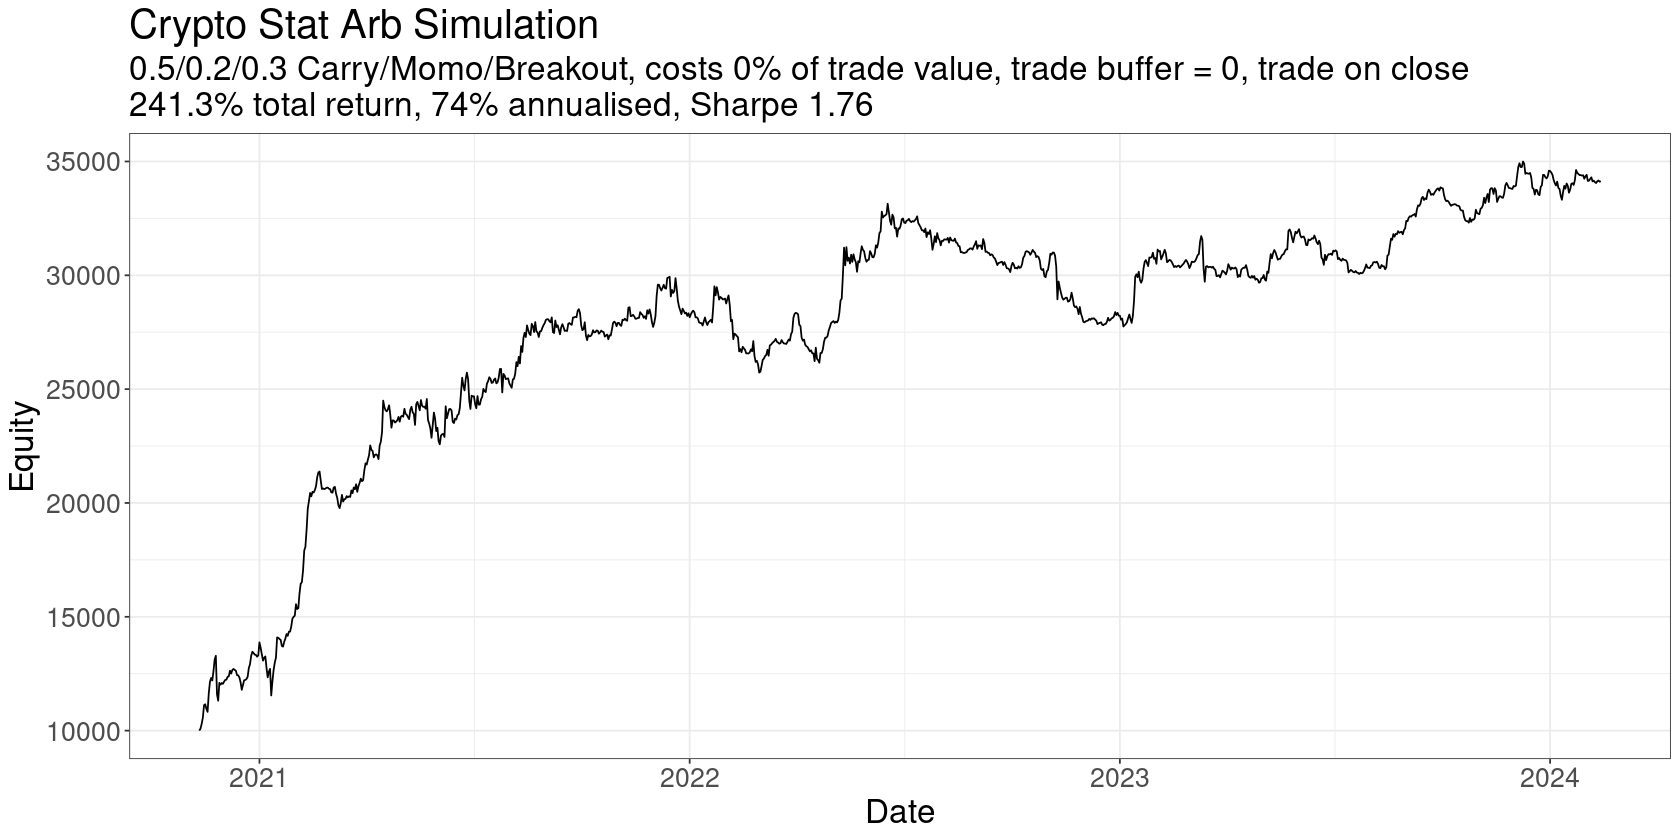

In [12]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
fee_tier <- 0
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

In [13]:
# check that actual weights match intended (can trade fractional contracts, so should be equal)
results_df %>%
  left_join(model_df %>% select(ticker, date, scaled_weight), by = c("ticker", "Date" = "date")) %>%
  group_by(Date) %>%
  mutate(
    actual_weight = Value/(initial_cash)
  )  %>%
  filter(scaled_weight != 0) %>%
  tail(10)

ticker,Date,Close,Position,Value,Margin,Funding,PeriodPnL,Trades,TradeValue,Commission,MarginCall,ReducedTargetPos,scaled_weight,actual_weight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CFXUSDT,2024-02-13,0.2192000,-1.070045e+03,-234.55378,11.727689,0.06922776,0.1405190,-7.135885e+02,-156.41860,0,0,0,-0.023455378,-0.023455378
ARBUSDT,2024-02-13,2.0327000,5.347353e+01,108.69565,5.434783,-0.02059611,0.8541669,1.969890e+01,40.04195,0,0,0,0.010869565,0.010869565
BLURUSDT,2024-02-13,0.6817000,-2.601519e+02,-177.34554,8.867277,0.09084505,-7.3657998,-1.191945e+02,-81.25490,0,0,0,-0.017734554,-0.017734554
SUIUSDT,2024-02-13,1.7847000,3.814524e+02,680.77803,34.038902,-0.20855505,1.5443030,-8.071655e+00,-14.40548,0,0,0,0.068077803,0.068077803
UMAUSDT,2024-02-13,4.2210000,5.014700e+01,211.67048,10.583524,0.34515420,59.8849311,1.879706e+02,793.42372,0,0,0,0.021167048,0.021167048
SEIUSDT,2024-02-13,0.7359000,3.809218e+02,280.32037,14.016018,-0.20655005,13.9411664,-2.797172e+01,-20.58439,0,0,0,0.028032037,0.028032037
TIAUSDT,2024-02-13,19.2523000,3.892667e+01,749.42792,37.471396,0.42387837,-14.1039051,2.579951e+00,49.66999,0,0,0,0.074942792,0.074942792
ORDIUSDT,2024-02-13,67.5660000,-2.794115e+00,-188.78719,9.439359,0.54223212,-14.9955991,2.451608e+00,165.64533,0,0,0,-0.018878719,-0.018878719
PYTHUSDT,2024-02-13,0.5799000,-1.085171e+02,-62.92906,3.146453,-0.03434807,1.5618746,-1.742053e+02,-101.02163,0,0,0,-0.006292906,-0.006292906


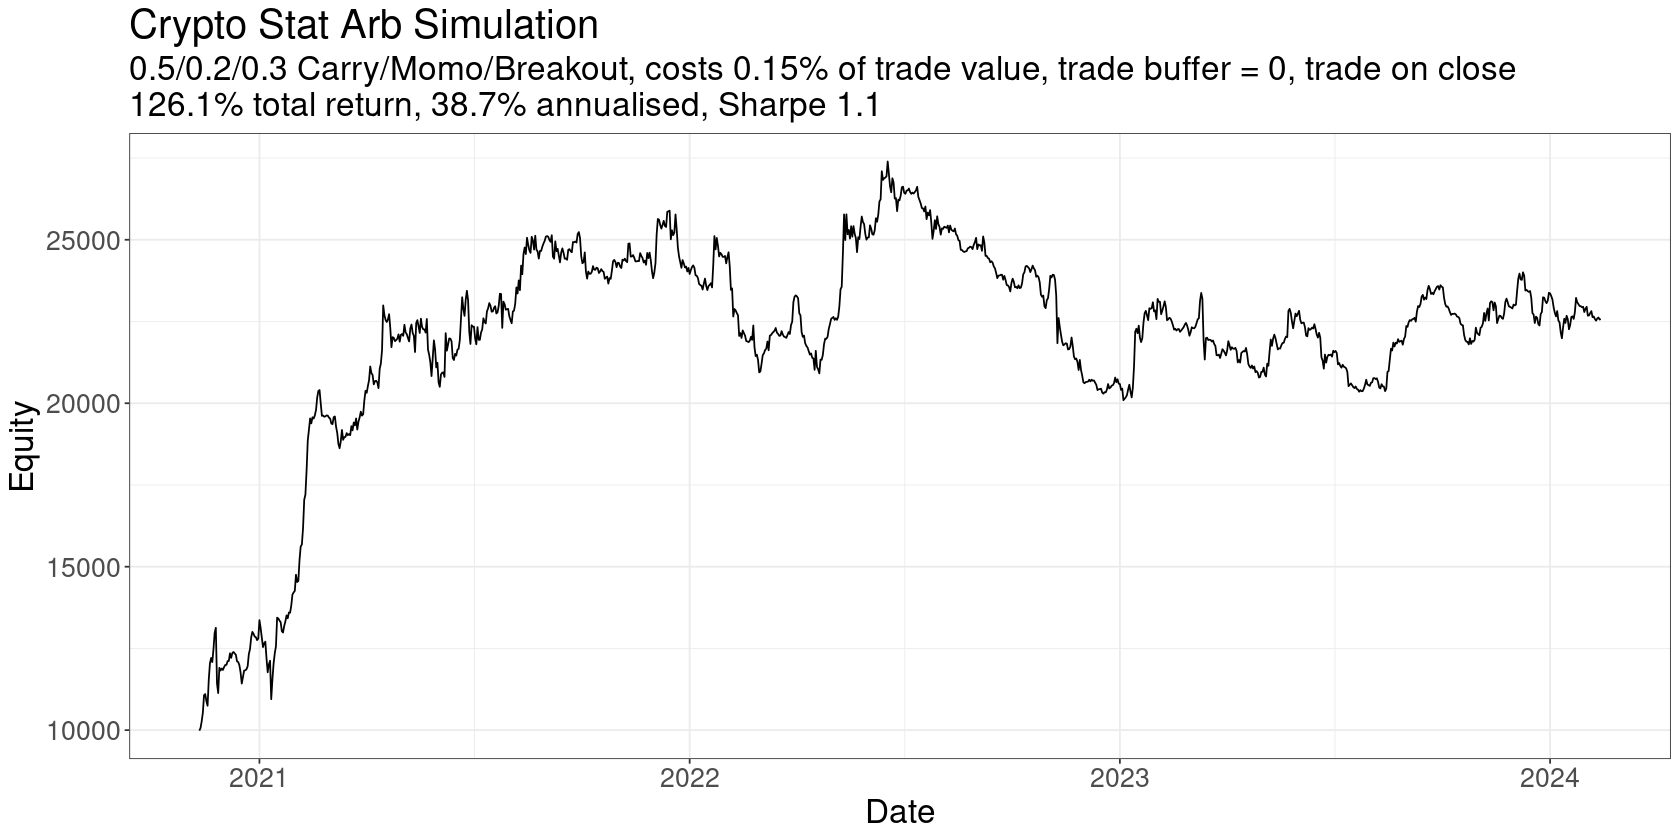

In [14]:
# explore costs-turnover tradeoffs
# with costs, no trade buffer
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

results_df %>%
  plot_results()

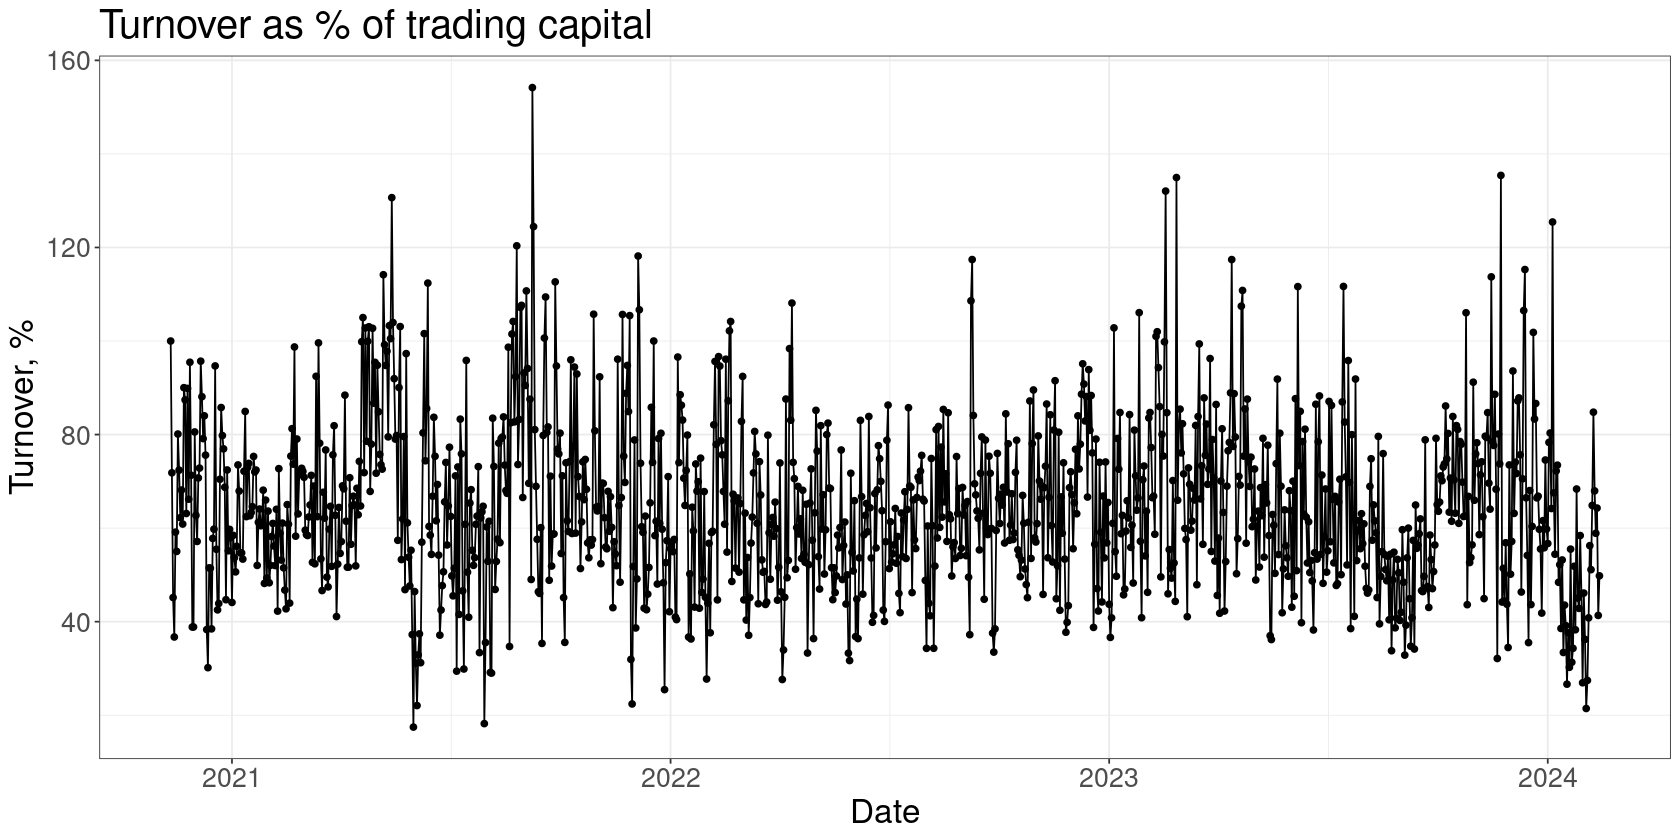

In [15]:
results_df %>%
  filter(ticker != "Cash") %>%
  group_by(Date) %>%
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>%
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

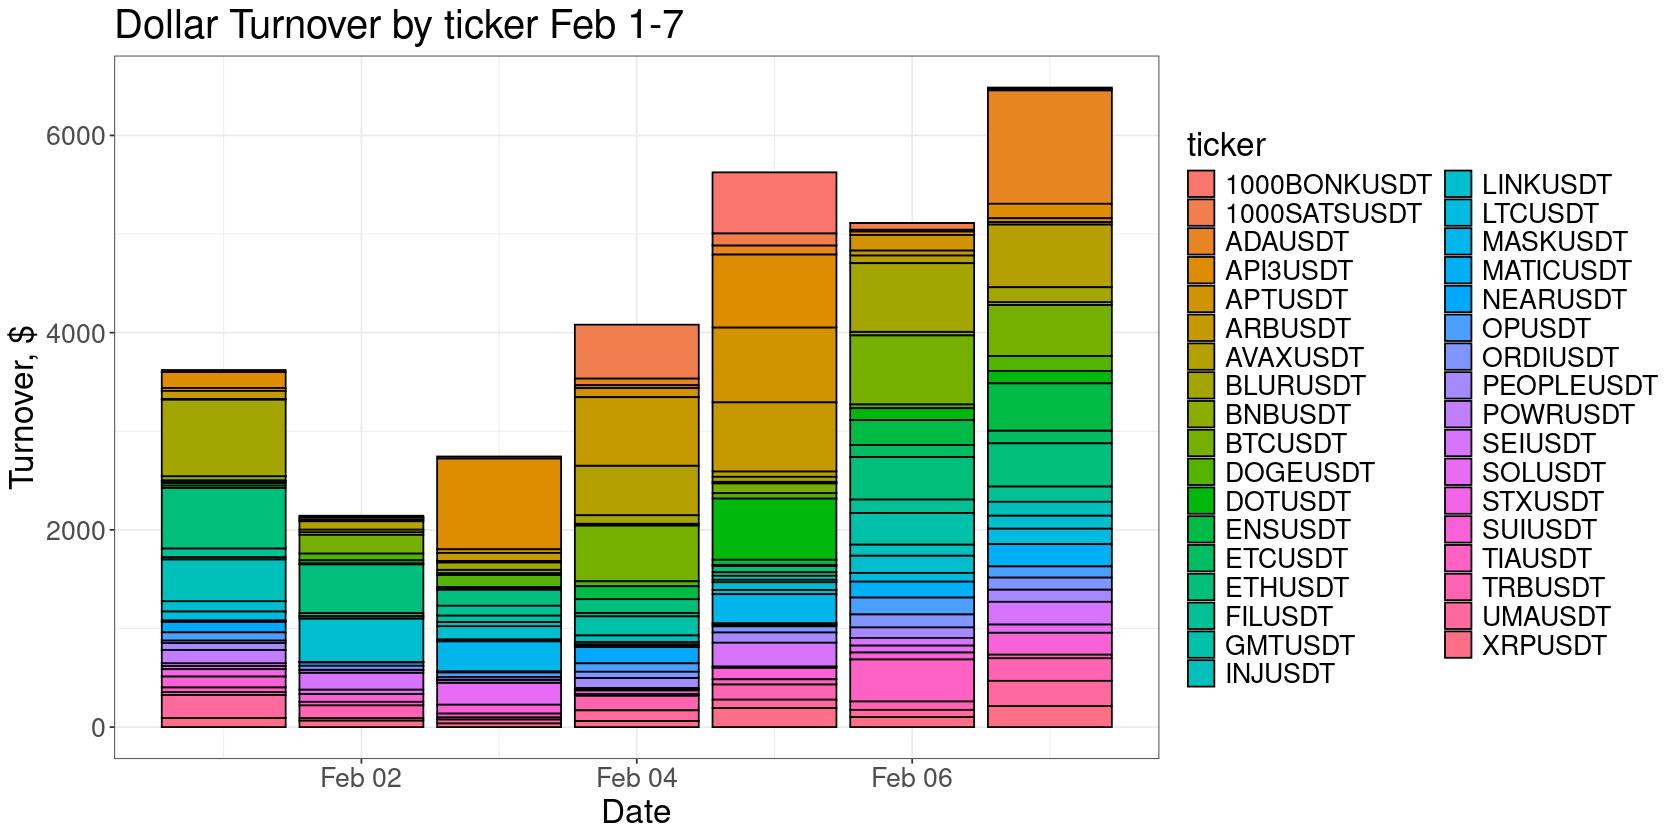

In [16]:
# on a particular few days
results_df %>%
  filter(Date >= "2024-02-01", Date <= "2024-02-07") %>%
  filter(abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = abs(TradeValue), fill = ticker)) +
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    labs(
        title = "Dollar Turnover by ticker Feb 1-7",
        y = "Turnover, $"
    )

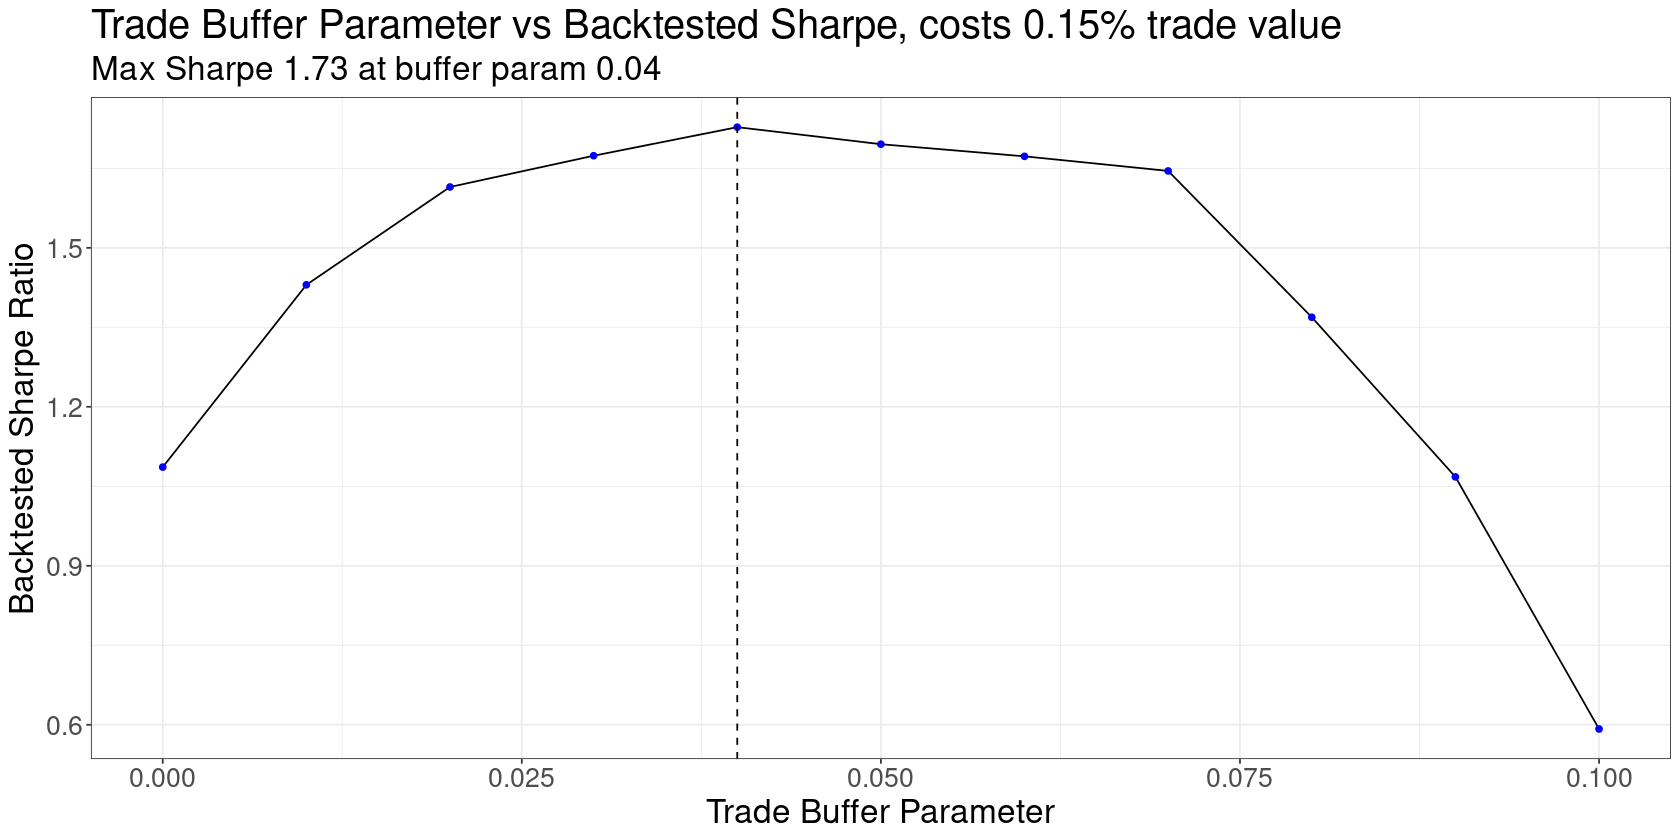

In [17]:
# find appropriate trade buffer by optimising historical sharpe
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    fixed_commission_backtest_with_funding(
      prices = backtest_prices,
      target_weights = backtest_weights,
      funding_rates = backtest_funding,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      margin = margin,
      commission_pct = commission_pct,
      capitalise_profits = capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

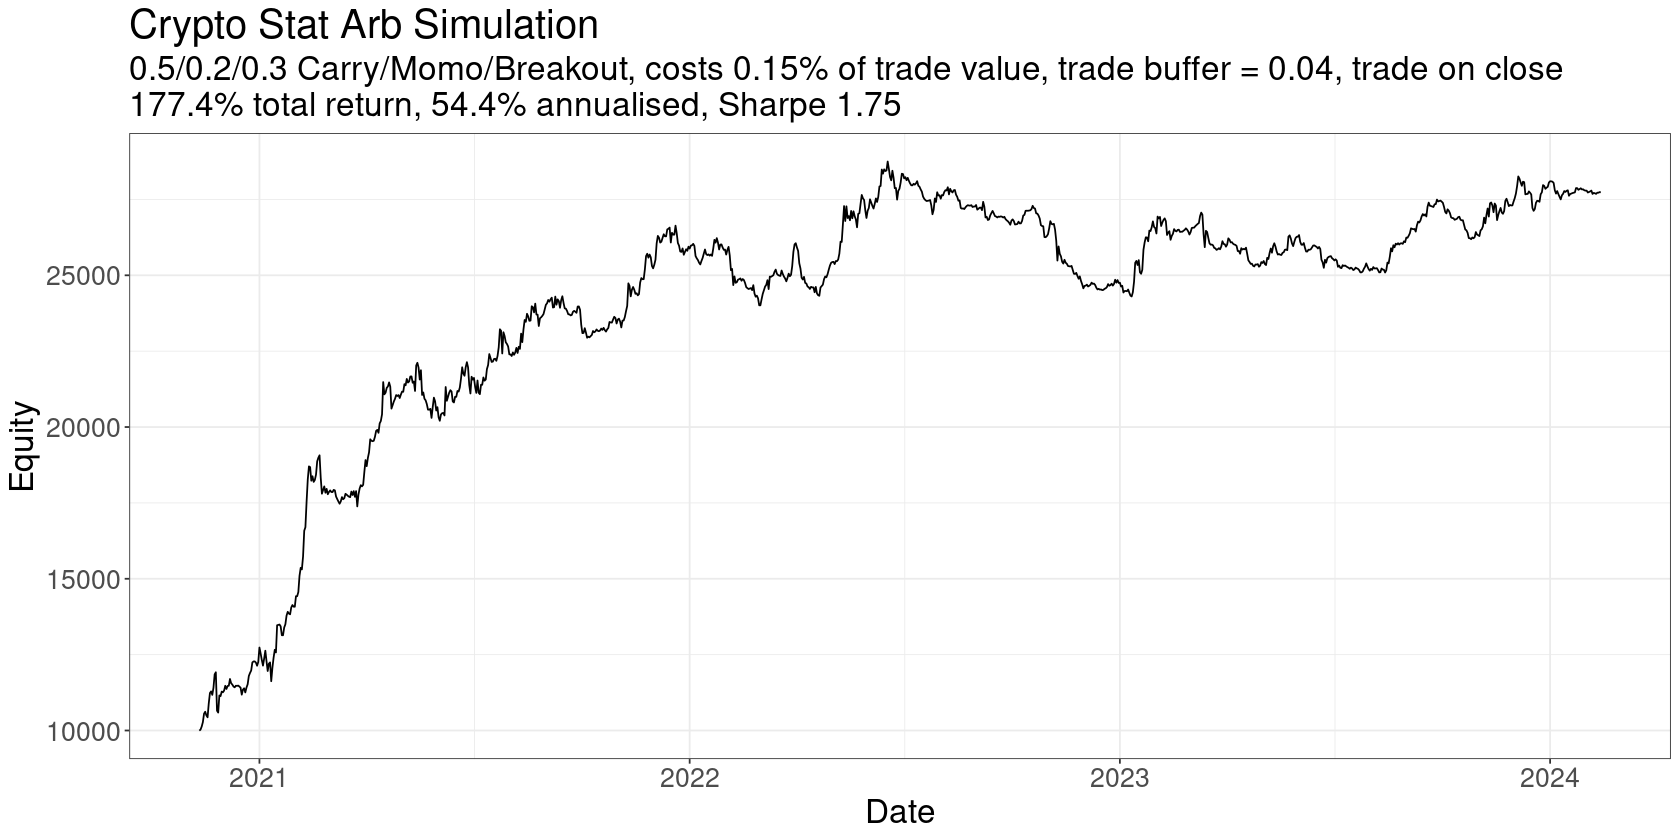

In [18]:
# get back original with costs simulation results
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.04
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- fixed_commission_backtest_with_funding(
    prices = backtest_prices,
    target_weights = backtest_weights,
    funding_rates = backtest_funding,
    trade_buffer = trade_buffer,
    initial_cash = initial_cash,
    margin = margin,
    commission_pct = commission_pct,
    capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# simulation results
results_df %>%
  plot_results()

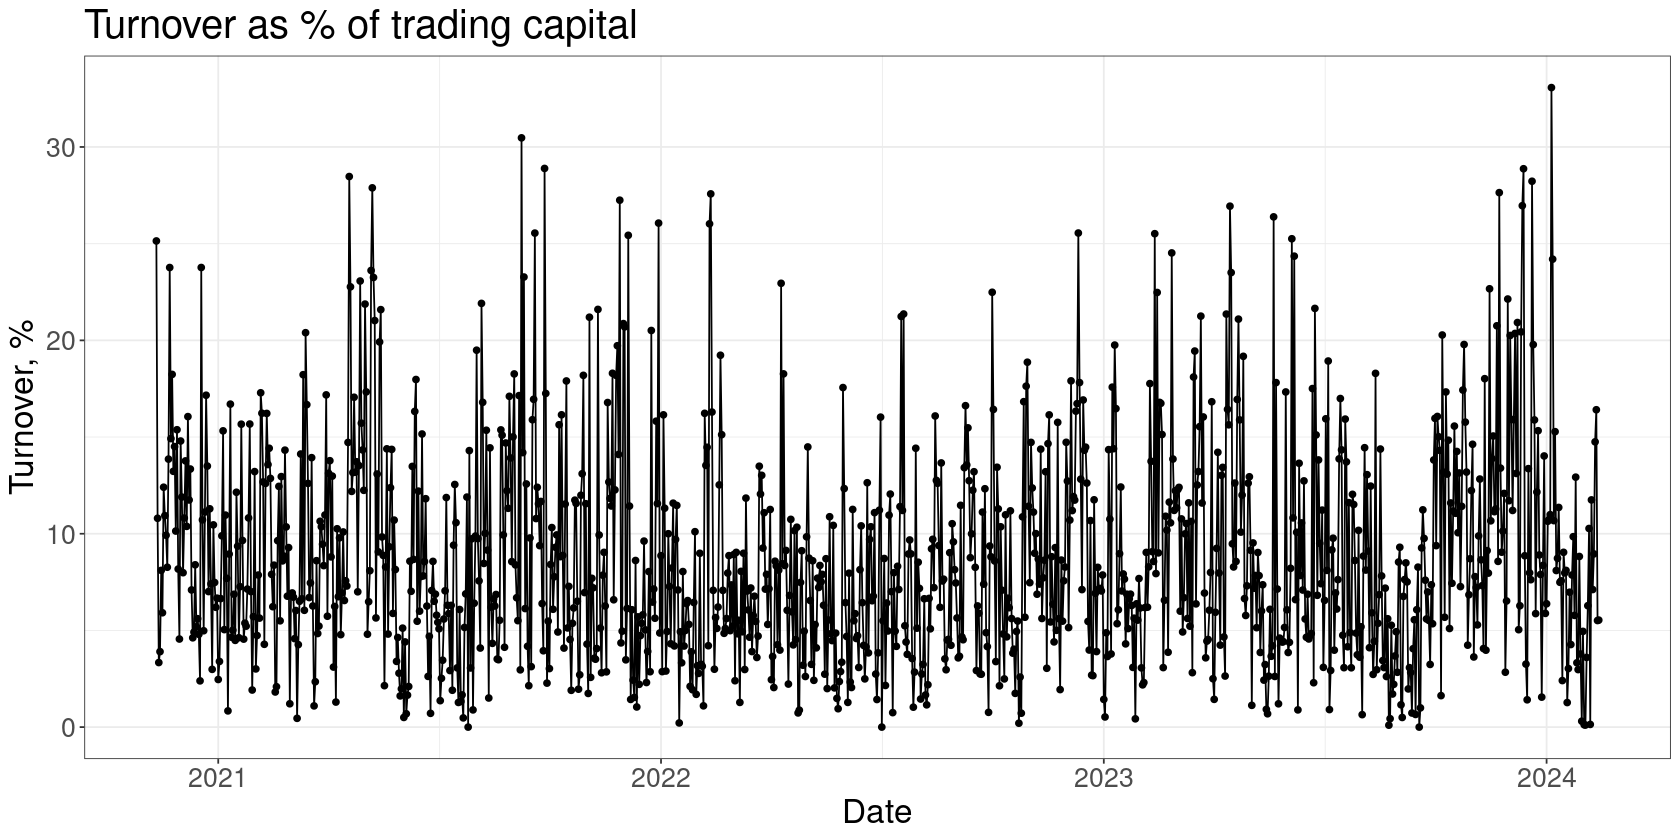

In [19]:
results_df %>%
  filter(ticker != "Cash") %>%
  group_by(Date) %>%
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>%
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

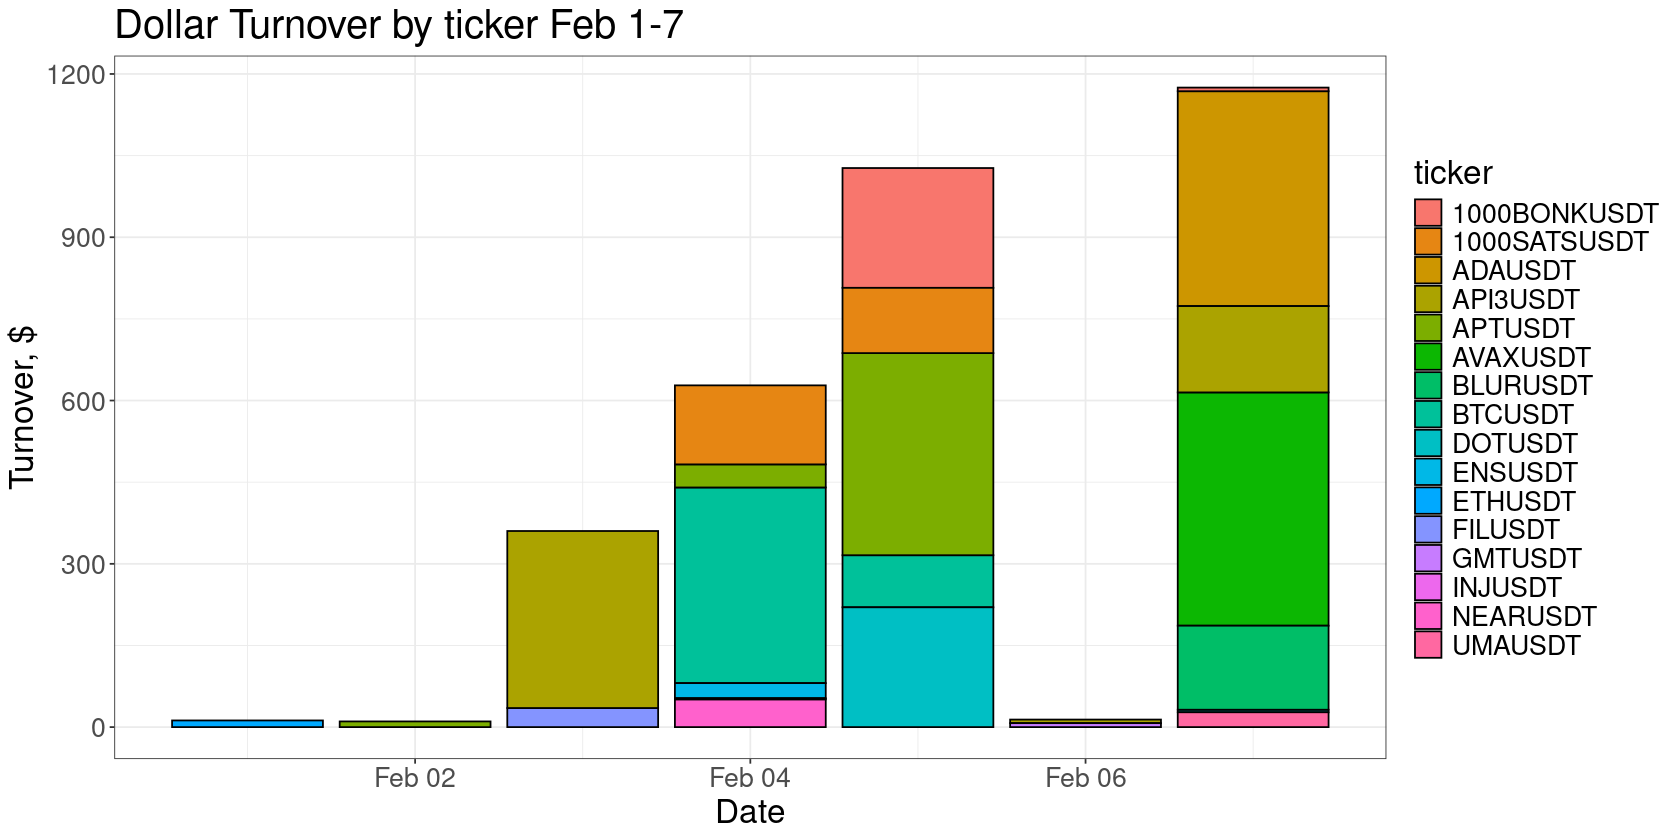

In [20]:
# on a particular few days
results_df %>%
  filter(Date >= "2024-02-01", Date <= "2024-02-07") %>%
  filter(abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = abs(TradeValue), fill = ticker)) +
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    labs(
        title = "Dollar Turnover by ticker Feb 1-7",
        y = "Turnover, $"
    )